## 1 Simple time series
Simple time series example: tracking state with linear dynamics

In [1]:
from pfilter import ParticleFilter, independent_sample, squared_error
from scipy.stats import norm, gamma, uniform 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Utility function to filter a time series offline and return results as a dictionary of states:

In [2]:
def apply_filter(pf, ys, inputs=None):
    """Apply filter pf to a series of observations (time_steps, h)  and return a dictionary:    
        particles: an array of particles (time_steps, n, d)
        weights: an array of weights (time_steps,)        
    """

    states = []
    pf.init_filter()  # reset
    for i,y in enumerate(ys):
        if inputs is None:
            pf.update(y)
        else:
            pf.update(y, **inputs[i])
            
        states.append([pf.transformed_particles, np.array(pf.weights)])
    return {
        name: np.array([s[i] for s in states])
        for i, name in enumerate(["particles", "weights"])
    }

In [3]:
def plot_particles(x, y, yn, states):
    """Plot a 1D tracking result as a line graph with overlaid
    scatterplot of particles. Particles are sized according to
    normalised weight at each step.
    
        x: time values
        y: original (uncorrupted) values
        yn: noisy (observed) values
        states: dictionary return from apply_pfilter        
    """
    fig, ax = plt.subplots()
    ax.plot(x, y, label='True', lw=1)
    ax.plot(x, yn, label='Noisy', lw=2)
    
    particles = states["particles"]
    ws = states["weights"]    
    means = np.sum(particles[:,:,0] * ws, axis=1)
    
    dev = (means - (particles[:,:,0]).T).T**2
    var = np.sum(ws * dev, axis=1)  / 1-np.sum(ws**2)  # unbiased variance
    stds = np.sqrt(var)
    
    ax.plot(x, means, 'C4', label='Mean est.', lw=4)
    ax.fill_between(x, means-stds, means+stds, color='C4', alpha=0.5, label='Std.')
    ax.scatter(np.tile(x, (len(particles[0]),1)).ravel(), particles[:,:,0].T, s=ws*1000/np.sqrt(len(ws)),
                alpha=0.15, label='Particles')
    ax.set_xlabel("Time")
    ax.set_ylabel("Observed")
    ax.legend()
    
def filter_plot(x, y, yn, pf, inputs=None):
    """Apply a filter to yn, and plot the results using plot_particles()"""
    states = apply_filter(pf, yn, inputs)
    plot_particles(x, y, yn, states)


## (a) Tracking a 1D sinewave

### Data
We generate a noisy (co)sine wave with a linear trend, and Gaussian noise added:

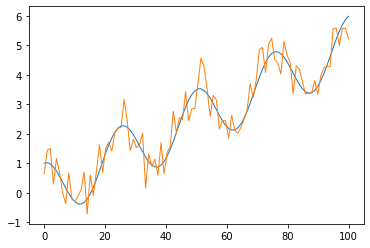

In [4]:
# Noisy sine wave data
x = np.linspace(0, 100, 100)
y = np.cos(x/4.0) + x * 0.05
yn = y + np.random.normal(0,0.5,x.shape)


fig, ax = plt.subplots()
ax.plot(x, y, label='True', lw=1)
ax.plot(x, yn, label='Noisy', lw=1)

### Purely stochastic dynamics (random walk)

c:\local\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


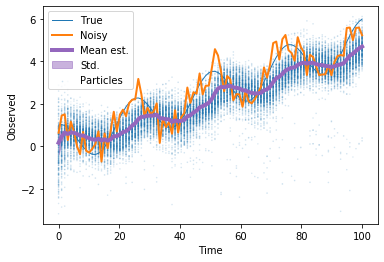

In [6]:
# No dynamics
# just diffusion on x
prior_fn = lambda n: np.random.normal(0,1,(n,1))
dt = 0.05
noise = 0.15
sigma = 1.5

pf = ParticleFilter(prior_fn = prior_fn, 
                    observe_fn = lambda x:  x,  
                    dynamics_fn=lambda x:   x ,
                    n_particles=250, 
                    noise_fn = lambda x: x + np.random.normal(0, noise, x.shape),
                    weight_fn = lambda x,y : squared_error(x, y, sigma=sigma),
                    resample_proportion=0.01)

filter_plot(x, y, yn, pf)

### Simple linear dynamics

c:\local\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


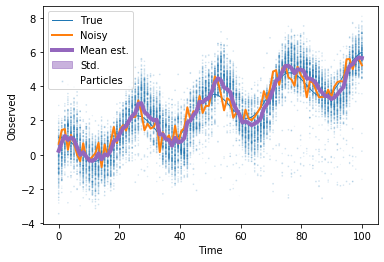

In [7]:
# Linear dynamics
# x, dx, ddx
prior_fn = lambda n: np.random.normal(0,1,(n,3))
dt = 0.25
noise = 0.125
sigma = 1.0

# linear dynamics
D = np.array([[1, dt, 0.5*dt**2],
               [0, 1, dt],
               [0, 0, 1]])

O = np.array([[1, 0, 0]])
pf = ParticleFilter(prior_fn = prior_fn, 
                    observe_fn = lambda x:  x @ O.T,  
                    dynamics_fn=lambda x:   x @ D.T ,
                    n_particles=200, 
                    noise_fn = lambda x: x + np.random.normal(0, noise, x.shape),
                    weight_fn = lambda x,y : squared_error(x, y, sigma=sigma),
                    resample_proportion=0.02)

filter_plot(x, y, yn, pf)


### Linear dynamics with missing values

c:\local\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


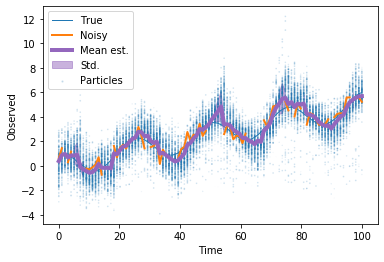

In [8]:
# Missing values; randomly delete 25% of the observations
y_missing = np.array([yt if np.random.uniform()>0.25 else None for yt in yn])
filter_plot(x, y, y_missing, pf)


### Latent variable estimation (cosine model)

c:\local\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


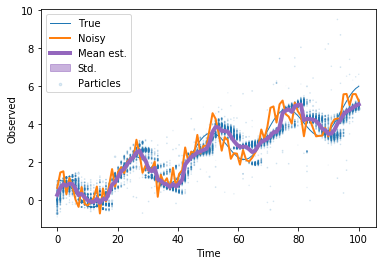

In [9]:
# Cosine estimation
# x = a cos(wt + p) + kt
# state = [a,w,p,k]

prior_fn = lambda n: np.random.uniform(0,1,(n,4)) * [1.0, 0.25, np.pi*2.0, 0.1]
noise = 0.0005
sigma = 0.5

def cos_observe(x, t):            
    return x[:,0] * np.cos(t * x[:,1] + x[:,2] ) + x[:,3] * t

ts = [{"t":t} for t in x]

pf = ParticleFilter(prior_fn = prior_fn, 
                    observe_fn = cos_observe,  
                    dynamics_fn = lambda x, **kwargs:x ,
                    n_particles=200, 
                    n_eff_threshold=1.0,
                    noise_fn = lambda x, **kwargs: x + np.random.normal(0, noise, x.shape) ,
                    weight_fn = lambda x,y, **kwargs: squared_error(x, y, sigma=sigma),
                    transform_fn = lambda x, weights, **kwargs: cos_observe(x, kwargs['t'])[:,None],
                    resample_proportion=0.01)

filter_plot(x, y, yn, pf, inputs=ts)
